# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC209B Advanced Topics in Data Science

## Final Project: Meow Meow -- Classification of Cat Sounds


**Harvard University**<br/>
**Spring 2024**<br/>
**Group Members**: Soline Boussard,  Niki Ekstrom, Michelle Hewson, Sydney Levy, Aida York

---

# Table of Contents
1. [Introduction](#introduction)
    1. [Problem Statement](#problemstatement)
    2. [Library Installation](#libraries)
2. [Data Loading & Cleaning](#dataloading)
    1. [Load in Data](#dataloading)
    2. [Clean/Preprocess Data](#dataclean)
3. [Exploratory Data Analysis](#eda)
4. [Baseline CNN Model](#baseline)
5. [Tuned CNN Model](#models)
6. [Transfer Learning Model](#transfer)
7. [Model Performance](#performance)
8. [Real Data](#real)
9. [Results](#results)
10. [Future Work/Scope of Improvement](#future)

# Introduction <a name="introduction"></a>

## Motivation

Pets are known as a man’s best friend. 66% of U.S. households own a pet and yet many people have no way of understanding their pets emotions. Through our project, we will focus specifically on cats and understanding what their different meows mean. We will focus on ten different emotions a cat can display through their meows: angry, defense, fighting, happy, hunting mind, mating, mother call, paining, resting, warning. 

We hope to create a model that generalizes to not only the cat meows in our training dataset, but to all cats throughout the U.S. We will display how our model works on the meows of our own personal cats This will allow pet owners across the country to better understand their cats and grow closer to each other. 


## Project Statement

How well can we classify the emotions of cat meows based on the 5,922 training audio files? Which features about the audio are most important for this classification task?


## Project Goal

The goal of this project is to see how well we can classify the emotions of cat meows based on the 5,922 training audio files. We want to achieve the highest accuracy possible and also understand which features of the audio are most important for this classification task. 
Through our EDA we found that we have relatively balanced class sizes which will allow us to use accuracy as our primary metric. We will look at both the overall accuracy of the model as well as the accuracy for each class (cat emotion). 


## Library Installations

In [39]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable


In [40]:
#!pip install numpy scipy matplotlib librosa IPython
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from random import randint
from IPython.display import Image
from IPython.display import Audio

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

## Library Dependencies

Many of the libraries we utilize in this project are common libraries that we have seen in class like numpy, pandas, matplotlib, sklearn, and tensorflow. One of the libraries that we depended on the most for our audio data is librosa. Librosa is a python package for music and audio analysis, which provides the necessary tools to extract audio features. We used this library to create mel spectrograms of the audio files so we could feed them into our CNN models to classify different cat meows based on their emotions. Mel spectrograms are visual representations of the spectrum of frequencies of a signal as it varies over time, aka a visual representation of the cat meows over time.

# Data Loading & Cleaning <a name="dataloading"></a>

## Data Description
Our data frame has 5,922 rows and 370,370 columns, where 370,368 columns are the individual amplitudes that are of type float. This means that we have 5,922 audio files of different cat noises and their labels. The two other columns are the emotion and the file path, and both are object types. None of the columns have null values. With each column representing the amplitude of the audio, it does not make sense to create traditional descriptive statistics. 


We created additional features to better visualize the data using the librosa python package. This package allowed us to compute the mel spectrogram and its logarithmic transformation of each audio signal. The mel spectrogram represents the frequency of the audio over time and its logarithmic transformation allows us to better visualize the lower-intensity components of the audio. Thus, both of these features will be important for allowing us to classify the emotions of the different cat meow audio files. 


In order to pass our audio data into the convolutional neural network, we needed to turn the data into images. First, we created PNG files for the log mel spectrogram of sample audio files for each emotion. We picked a random index for each emotion in our dataset and visualized its log mel spectrogram, which captures how the frequency of the audio changes over time. A log mel spectrogram includes the vertical axis displaying frequency in Hertz, the horizontal axis representing time of the audio track, and amplitude being represented by brightness/color. The black background is silence and the bright curve is the sine wave moving up in pitch.


## Reading in the audio files

In [42]:
directory = "NAYA_DATA_AUG1X"

audio_data_list = []
file_paths_list = []
emotions_list = []

ms = []
log_ms = []

for root, dirs, files in os.walk(directory):
    for file in files:
        file_path = os.path.join(root, file)
        # Check if the file is an mp3 file
        if file_path.endswith(".mp3"):
            # Load audio data
            audio_data, sr = librosa.load(file_path)

            # Desired length in samples
            desired_length = int(5 * sr)  
            
            # Pad or truncate the signal to the desired length
            audio_padded = librosa.util.fix_length(audio_data, size=desired_length)
            
            mel_spec = librosa.feature.melspectrogram(y=audio_padded, sr=sr)

            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            normalized_log_mel_spec = (log_mel_spec - np.min(log_mel_spec)) / (np.max(log_mel_spec) - np.min(log_mel_spec))

            log_ms.append(normalized_log_mel_spec)
            ms.append(mel_spec)

            # Append audio data and file path to the respective lists
            audio_data_list.append(audio_padded)
            file_paths_list.append(file_path)
            
            # Extract emotion from the directory name
            emotion = os.path.basename(os.path.dirname(file_path))
            emotions_list.append(emotion)

Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


In [43]:
# Convert the data into a Pandas dataframe
data = {
    'File_Path': file_paths_list,
    'Audio_Data': audio_data_list,
    'Emotion': emotions_list
}

df = pd.DataFrame(data)
df.head()

,File_Path,Audio_Data,Emotion
0,NAYA_DATA_AUG1X/Fighting/car_extcoll0101.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Fighting
1,NAYA_DATA_AUG1X/Fighting/cat0334.mp3,"[-2.3283064e-10, -1.1641532e-09, 0.0, -2.09547...",Fighting
2,NAYA_DATA_AUG1X/Fighting/YashLL_Cat0236Fit.mp3,"[2.0954758e-08, 3.3527613e-08, -7.450581e-09, ...",Fighting
3,NAYA_DATA_AUG1X/Fighting/YashLL_Cat0237Fit_aug...,"[-6.1647035e-05, -6.317347e-05, -8.239411e-05,...",Fighting
4,NAYA_DATA_AUG1X/Fighting/Last_addCat363Fit_aug...,"[0.0002870597, 0.00075750623, 0.0008200917, -3...",Fighting


In [44]:
df.shape

(5940, 3)

## Cleaning and Preprocessing the Data

### Missing Data: 
Some audio files are longer than others. For these cases, we padded the shorter audio files with 0. We did not shorten any audio files in case important sounds were recorded during the beginning or end of longer audio files. 

### Data Imbalance:
Our data is relatively balanced, with each emotion within 5% of the others:
- Mating: 602 sounds
- Warning: 600 sounds
- Angry: 600 sounds
- Fighting: 600 sounds
- Happy: 594 sounds
- Mother call: 592 sounds
- Resting: 592 sounds
- Paining: 582 sounds
- Defense: 582 sounds
- HuntingMind: 578 sounds

Therefore, we did not address data imbalance in this notebook.

In [45]:
emotion_counts = df['Emotion'].value_counts()
print(emotion_counts)

Emotion
Mating         602
Fighting       600
Warning        600
Defence        600
Angry          600
Happy          594
Resting        592
MotherCall     592
Paining        582
HuntingMind    578
Name: count, dtype: int64


# Exploratory Data Analysis <a name="eda"></a>

## Data Visualization

First, we want to actually listen to what the data we are dealing with sounds like. Play the below audio to hear what an angry cat meow sounds like in this dataset.

In [46]:
mp3_file_path = "NAYA_DATA_AUG1X/Angry/car_extcoll0103_aug1(1).mp3"
Audio(mp3_file_path)

We wanted to visualize a single audio waveform to understand what 1 row of our data represents visually. This is the audio visualization of the angry cat audio from above. Note the silence after 3 seconds because we padded the data so that all files are 5 seconds long.

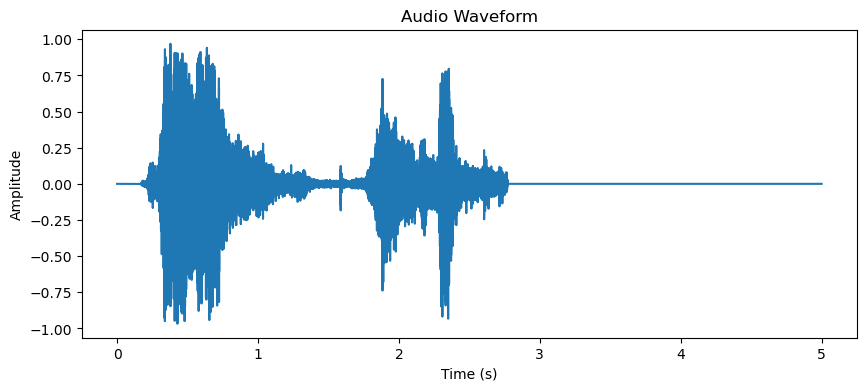

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(df.Audio_Data[0])) / sr, df.Audio_Data[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

Second, we wanted to visualize the audio waveforms for sample audios of each meow emotion. This allows us to compare the amplitude of the audio waveforms for each emotion over time. Observe that each emotion is characterized by distinct waveforms, highlighting the unique representation of each emotion. However, some emotions are very similar in this example. Notice that Mating and Happy both have similar shapes, while Defence and MotherCall do, too.

In [48]:
# Get one example meow from each emotion
def get_random_indices(df):
    random_indices = {}
    for emotion in df['Emotion'].unique():
        # Filter DataFrame by emotion
        emotion_df = df[df['Emotion'] == emotion]
        # Randomly select one index
        random_index = np.random.choice(emotion_df.index)
        random_indices[emotion] = random_index
    return random_indices

emotion_dict = get_random_indices(df)

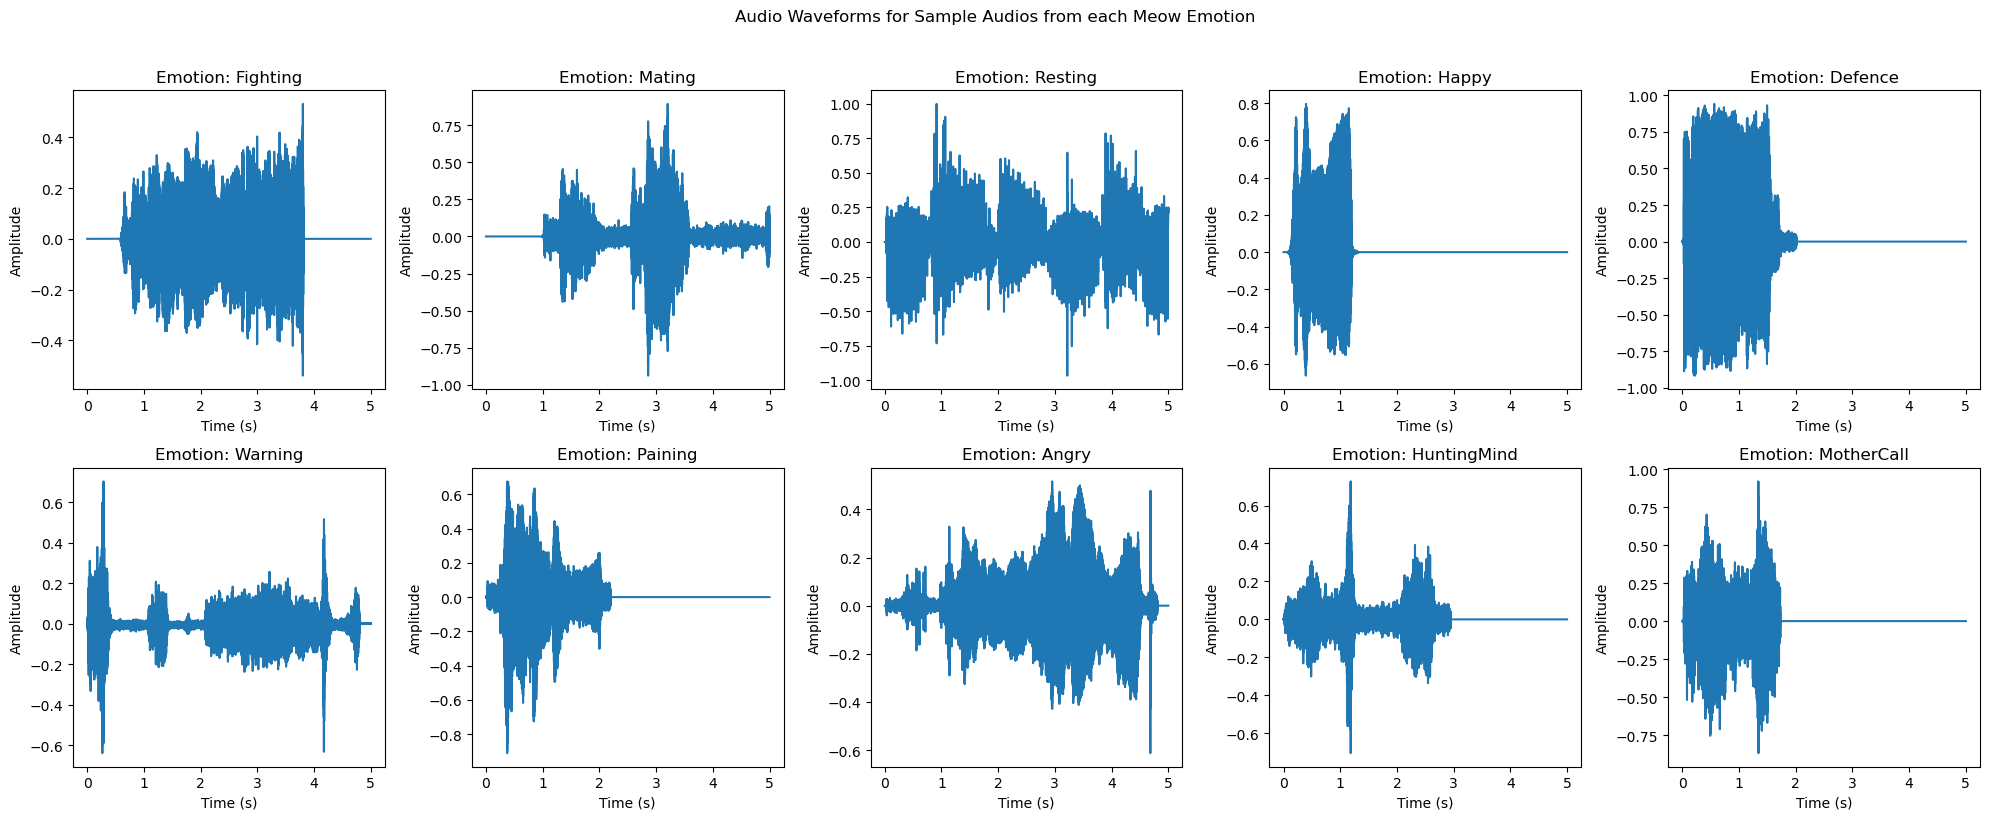

In [49]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (emotion, index) in enumerate(emotion_dict.items()):
    audio_data = df.loc[index, 'Audio_Data']
    time = np.arange(len(audio_data)) / sr
    axes[i].plot(time, audio_data)
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude')
    axes[i].set_title(f'Emotion: {emotion}')

fig.suptitle("Audio Waveforms for Sample Audios from each Meow Emotion", y=1.02)  
plt.tight_layout()
plt.show()

Here, we visualize different mel spectrograms for each Meow emotion. A mel spectrogram is a representation of the short-term power spectrum of a sound, where the frequencies are converted into the mel scale. The values in the mel spectrogram represent the power (or magnitude) of each frequency bin over time. As you can see, the plots are not very descriptive.

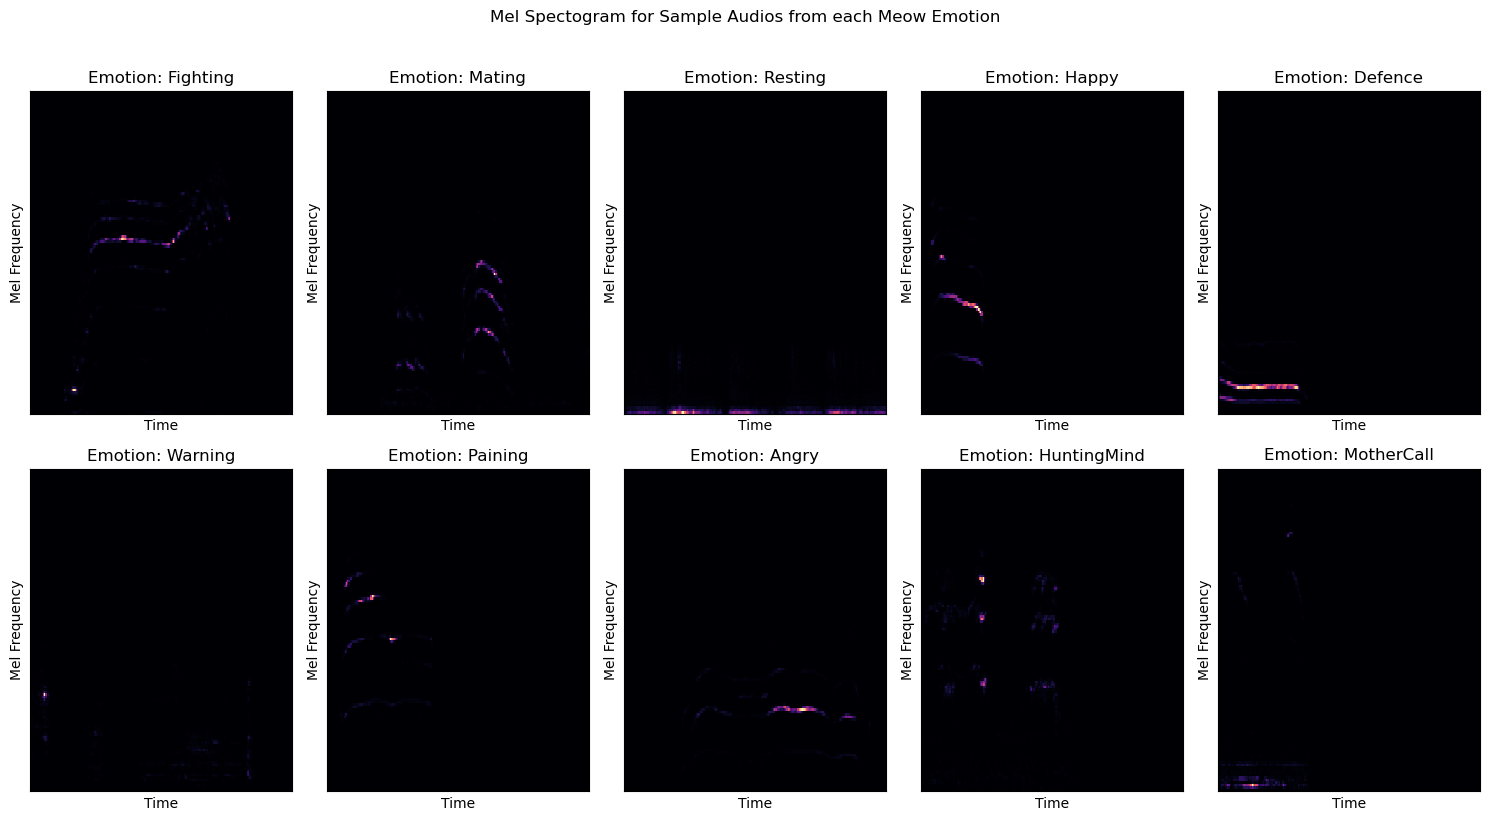

In [50]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

axes = axes.flatten()

for i, (emotion, index) in enumerate(emotion_dict.items()):
    sample_log_ms = ms[index]
    librosa.display.specshow(sample_log_ms, sr=sr, ax=axes[i])
    axes[i].set_title(f"Emotion: {emotion}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

fig.suptitle("Mel Spectogram for Sample Audios from each Meow Emotion", y=1.02)
plt.tight_layout()
plt.show()

In the next visualization we see the Log Mel Spectrogram for sample audios from each meow emotion. This results in a better visualization because because human perception of loudness is approximately logarithmic, therefore we use a logarithmic transformation to the values of the mel spectrogram. In these visualizations, the mel spectrogram is converted to decibel (dB) units, which is on the logarithmic scale.

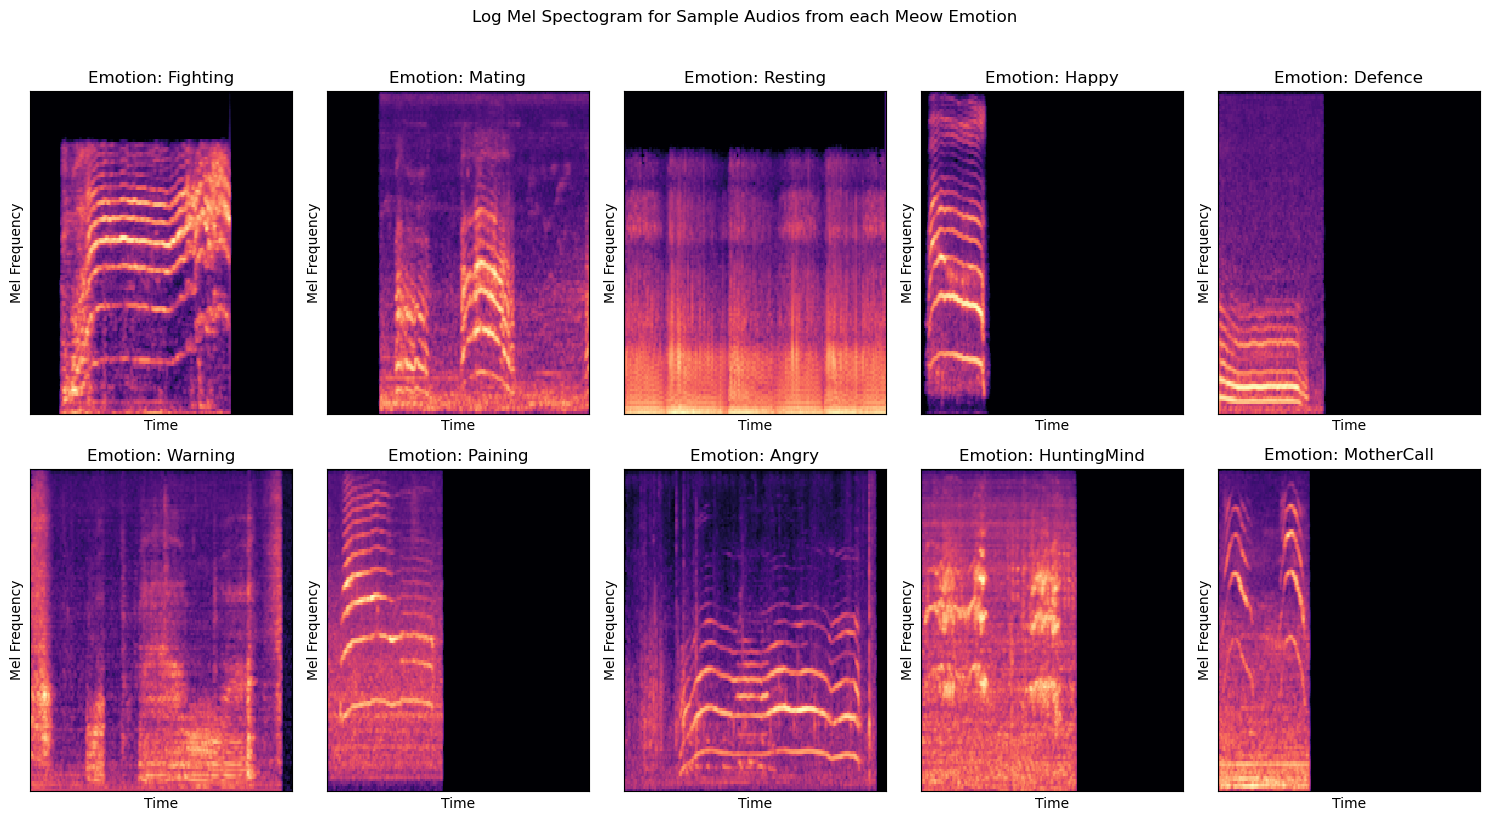

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

axes = axes.flatten()

for i, (emotion, index) in enumerate(emotion_dict.items()):
    sample_log_ms = log_ms[index]
    librosa.display.specshow(sample_log_ms, sr=sr, ax=axes[i])
    axes[i].set_title(f"Emotion: {emotion}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

fig.suptitle("Log Mel Spectogram for Sample Audios from each Meow Emotion", y=1.02)
plt.tight_layout()
plt.show()

In order to pass our audio data into the convolutional neural network, we needed to turn the data into images. We created PNG files for the log mel spectrogram of sample audio files for each emotion. A log mel spectrogram includes the vertical axis displaying frequency in Hertz, the horizontal axis representing time of the audio track, and amplitude being represented by brightness/color. The black background is silence and the bright curve is the sine wave moving up in pitch.


## Summary of EDA findings

Overall, we found that it was relatively difficult to perform EDA on audio data. Once we were able to convert the audio files to spectrograms we were able to actually visualize the data we will be training our future model with. The spectrograms provide a unique insight into the types of audio associated with the various cat emotions. We also found that cat emotions with negative connotations, like defense, hunting, and fighting, have higher average pitches with a larger range than emotions like happy and resting. Thus, based on our exploratory data analysis, we believe that the mel spectrogram, log mel spectrogram, and audio pitch will all be important features to pass into our model for the emotion classification task. 


Once we were able to convert the audio files to spectrograms we were able to actually visualize the data we will be training our future model with. The spectrograms provide a unique insight into the types of audio associated with the various cat emotions. Some emotions show clear lines in the mel spectrograms, while others show a more uniform amplitude over the frequencies. When listening to the emotions corresponding to the emotions, we found that those with clear spectrogram lines have more of a clear tone. We also found that cat emotions with negative connotations, like defense, hunting, and fighting, have higher average pitches with a larger range than emotions like happy and resting. Thus, based on our exploratory data analysis, we believe that the mel spectrogram, log mel spectrogram, and audio pitch will all be important features to pass into our model for the emotion classification task. We also found that all the audio files did not have the same lengths, thus we should do some preprocessing before training our model. Finally, the emotions are currently categorical data which we would have to adapt for our model outcome. 


Each audio file was a different number of seconds. To build a CNN model, we therefore padded each audio file to be the length of the longest audio file. We can see the difference in range in the image below. 
The 10 labels were found as the title of the folder that each audio file was in. Therefore, we one-hot encoded the emotions.


# Baseline CNN Model <a name="baseline"></a>

Given the large size of our dataset, we took advantage of the TensorFlow pipeline to convert our dataset into a TensorFlow dataset. This allows us to batch the data when feeding it into the model for better computational efficiency and memory management. 
For our baseline model, we ran a basic CNN on our dataset. We chose a CNN model for processing the audio images because CNNs can capture hierarchical patterns in spectral features. Our model includes three convolutional layers, three pooling layers, a flattened layer, a dense layer, a dropout layer, and a final dense layer with a softmax activation. The convolutional layers have 32 filters, 64 filters and the last one has 128 filters. Following the compilation of our model, we ended up with  44,330,890 parameters. We ran the model for 10 epochs to get a baseline understanding of how the model is performing with our data. To evaluate the model, we used accuracy as our metric, as our dataset is pretty balanced between the emotions. 


## Build dataset for model and split into train/test

In [53]:
label_encoder = LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions_list)
emotions_onehot = to_categorical(emotions_encoded)

# create tensorflow datasets from spectrograms and labels
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((log_ms, emotions_onehot))
dataset = dataset.shuffle(10000) 
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [54]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    log_ms, emotions_onehot, test_size=0.15, random_state=42)

# split the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42) 

In [55]:
# Convert training data into a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Convert validation data into a TensorFlow dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Convert test data into a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Check that the training, validation and test datasets are balanced

In [56]:
def check_class_distribution(dataset, label_encoder):
    all_labels = np.concatenate([y.numpy() for x, y in dataset], axis=0)
    decoded_labels = label_encoder.inverse_transform([np.argmax(label) for label in all_labels])
    class_counts = np.unique(decoded_labels, return_counts=True)
    return dict(zip(class_counts[0], class_counts[1]))

train_distribution = check_class_distribution(train_dataset, label_encoder)
val_distribution = check_class_distribution(val_dataset, label_encoder)
test_distribution = check_class_distribution(test_dataset, label_encoder)

print("Training set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)
print("Test set distribution:", test_distribution)

Training set distribution: {'Angry': 436, 'Defence': 422, 'Fighting': 425, 'Happy': 420, 'HuntingMind': 435, 'Mating': 435, 'MotherCall': 433, 'Paining': 417, 'Resting': 419, 'Warning': 449}
Validation set distribution: {'Angry': 86, 'Defence': 82, 'Fighting': 66, 'Happy': 77, 'HuntingMind': 77, 'Mating': 87, 'MotherCall': 65, 'Paining': 68, 'Resting': 83, 'Warning': 67}
Test set distribution: {'Angry': 78, 'Defence': 96, 'Fighting': 109, 'Happy': 97, 'HuntingMind': 66, 'Mating': 80, 'MotherCall': 94, 'Paining': 97, 'Resting': 90, 'Warning': 84}


## Build baseline model

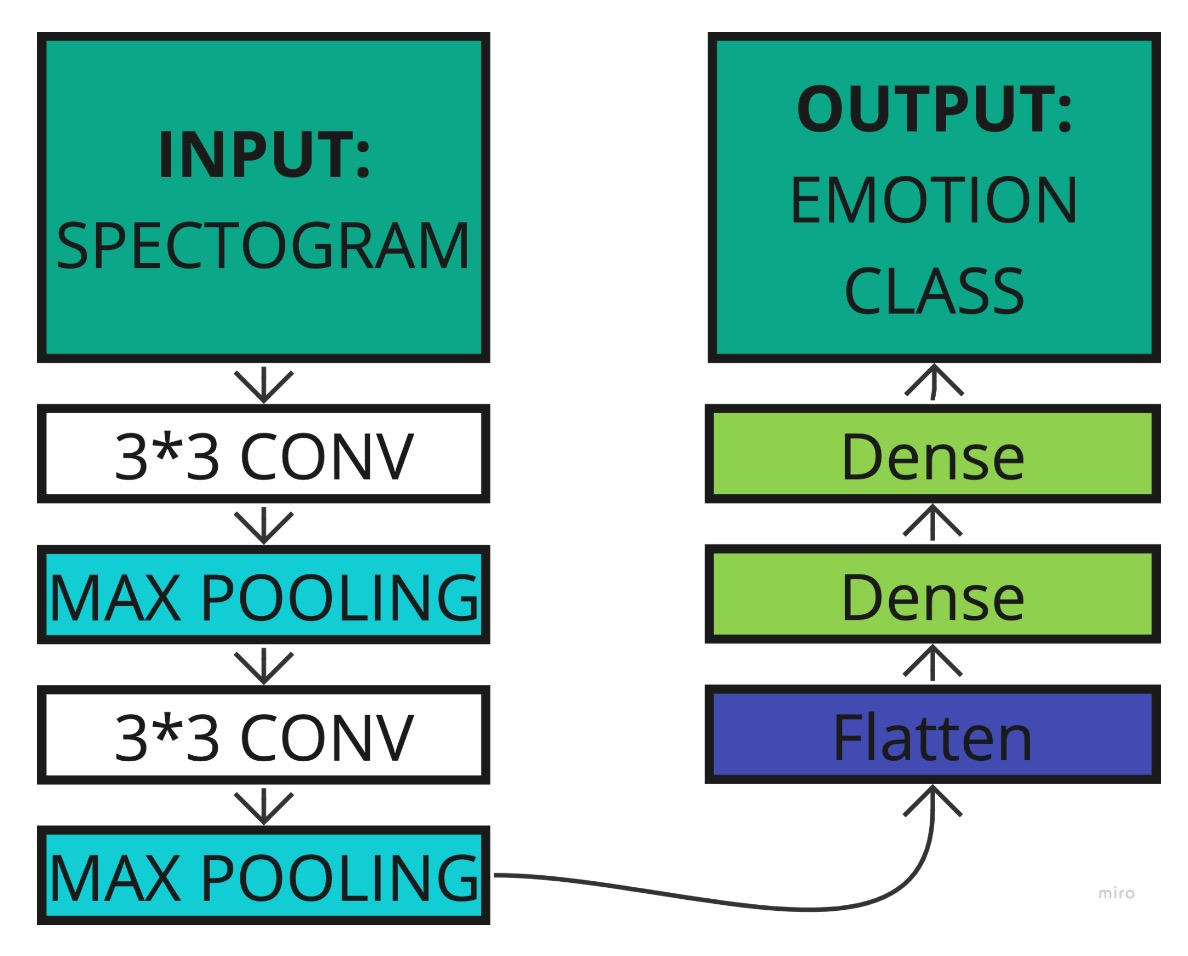

In [15]:
import IPython
IPython.display.Image("baseline.jpg")

In [156]:
baseline_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, log_ms[0].shape[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flattening the 3D outputs to 1D and adding Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    
    # Output layer
    Dense(emotions_onehot.shape[1], activation='softmax')
])

baseline_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 214, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 107, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 63, 107, 64)       18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 31, 53, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 105152)            0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [157]:
baseline_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [158]:
epochs = 15

history = baseline_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

Epoch 1/15
135/135 [==============================] - 5s 25ms/step - loss: 1.8434 - accuracy: 0.3414 - val_loss: 1.4085 - val_accuracy: 0.4974
Epoch 2/15
135/135 [==============================] - 3s 23ms/step - loss: 1.1248 - accuracy: 0.5887 - val_loss: 1.0983 - val_accuracy: 0.6095
Epoch 3/15
135/135 [==============================] - 3s 23ms/step - loss: 0.8100 - accuracy: 0.7008 - val_loss: 1.0462 - val_accuracy: 0.6121
Epoch 4/15
135/135 [==============================] - 3s 23ms/step - loss: 0.5833 - accuracy: 0.7732 - val_loss: 1.0754 - val_accuracy: 0.6253
Epoch 5/15
135/135 [==============================] - 3s 23ms/step - loss: 0.4451 - accuracy: 0.8210 - val_loss: 0.8978 - val_accuracy: 0.6992
Epoch 6/15
135/135 [==============================] - 3s 23ms/step - loss: 0.2732 - accuracy: 0.8781 - val_loss: 0.8637 - val_accuracy: 0.6913
Epoch 7/15
135/135 [==============================] - 3s 23ms/step - loss: 0.2225 - accuracy: 0.8902 - val_loss: 0.9665 - val_accuracy: 0.6834

In [60]:
test_loss, test_accuracy = baseline_model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

28/28 [==============================] - 0s 7ms/step - loss: 1.1097 - accuracy: 0.6790
Test loss: 1.1097205877304077, Test accuracy: 0.6790123581886292


## Analyze baseline model

- The model’s validation loss after 5 epochs is 1.0651 and the model’s validation accuracy was 0.7232. The test accuracy was 0.7008. The validation and test accuracy are a lot lower than the training accuracy (0.7232 compared to 0.9116), suggesting that there is overfitting. 

- A strength of the model is that it was able to achieve 72.3% validation accuracy and 70.1% test accuracy in only 5 epochs. This suggests that with additional training time we could achieve even higher accuracy without having to complicate the model. 
- One potential weakness of the model is its complexity, with over 22 million parameters which means that it is computationally intensive and requires a lot of memory.  
- For the next iteration, we may add regularization techniques and early stopping to address the overfitting. We can also add data augmentation to allow for a more generalizable model.

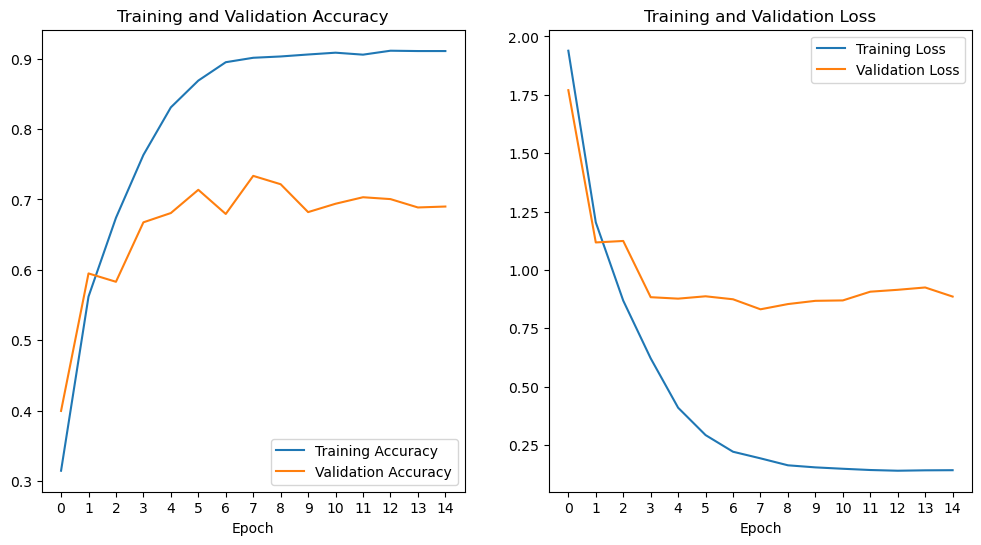

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))  # the number of epochs
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)  
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(epochs_range)
plt.xlabel('Epoch')

# Subplot for loss
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xticks(epochs_range)
plt.xlabel('Epoch');

The initial results suggest that a baseline CNN is able to achieve a 70.1% test accuracy. In order to align with our project goal we will also want to understand the accuracy the model achieves for each individual class label (all of the different cat emotions). Thus, in addition to achieving a model that has high overall accuracy we also want a model that does not completely discount some classes over others. 

1/1 [==============================] - 0s 100ms/step


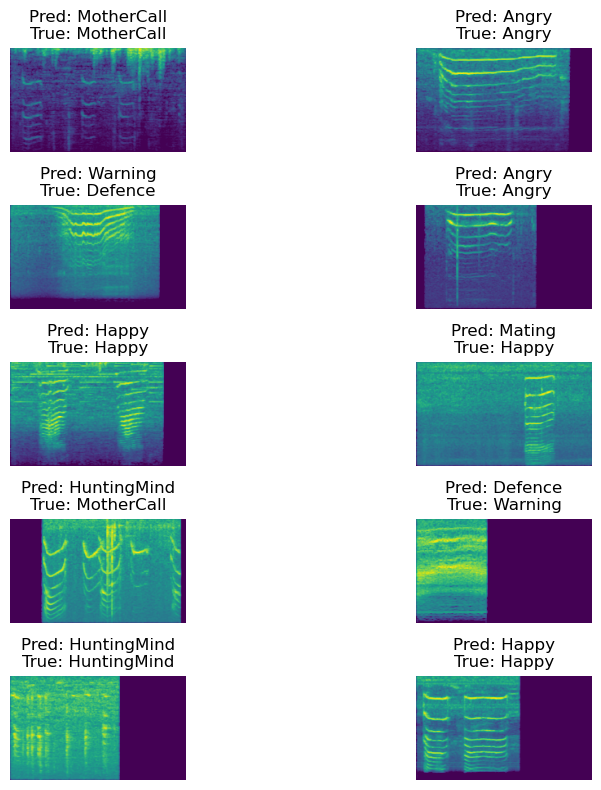

In [21]:
for test_images, test_labels in test_dataset.take(1):  # Take one batch from the test dataset
    predictions = baseline_model.predict(test_images)  # Get predictions for that batch
    predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
    true_classes = np.argmax(test_labels, axis=1)  

    # Get the true and predicted labels
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    true_labels = label_encoder.inverse_transform(true_classes)

    # Plot six images from this batch
    fig, axes = plt.subplots(5, 2, figsize=(10, 8))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        non_padded_mask = np.any(test_images[i].numpy() != 0, axis=0)
        # Plot only the non-padded part of the spectrogram
        ax.imshow(test_images[i].numpy().squeeze())
        ax.set_title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    break

## Understanding baseline model through feature/saliency maps

1/1 [==============================] - 0s 115ms/step


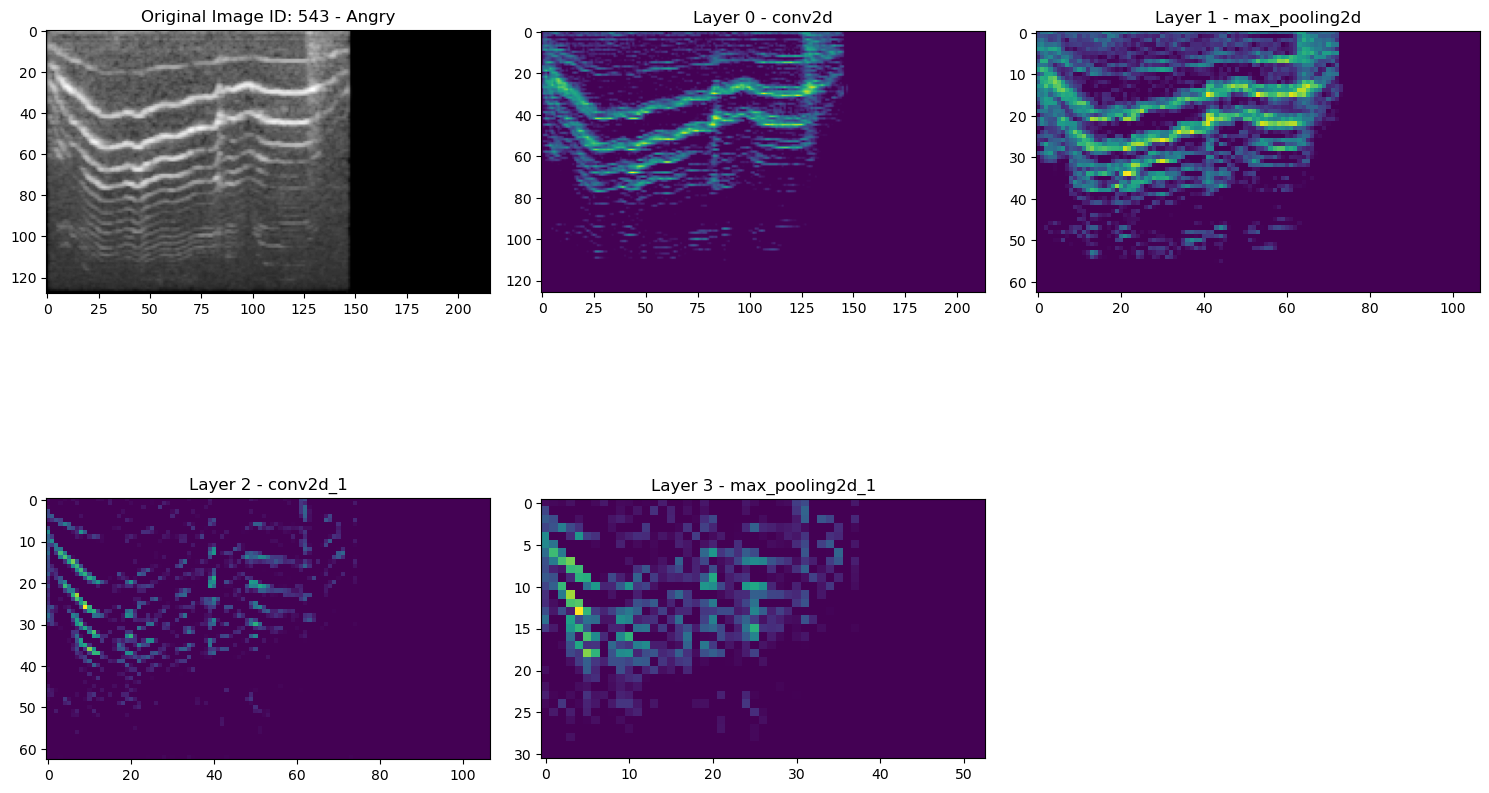

In [22]:
def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], 
                   outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

def plot_features_map(img_idx=None, layer_idx=range(4), 
                      x_test=X_test, ytest=y_test, model=baseline_model):
    if img_idx is None:
        img_idx = randint(0, ytest.shape[0])
    input_image = X_test[img_idx]
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))  
    ax[0][0].imshow(input_image.squeeze(), cmap='gray') 
    ax[0][0].set_title('Original Image ID: {} - {}'.format(img_idx, labels[np.argmax(ytest[img_idx])]))
    for i, l in enumerate(layer_idx):
        feature_map = get_feature_maps(baseline_model, l, input_image)
        ax[(i+1)//3][(i+1)%3].imshow(feature_map[0], cmap='viridis')
        ax[(i+1)//3][(i+1)%3].set_title('Layer {} - {}'.format(l, baseline_model.layers[l].name))
    fig.delaxes(ax[1, 2])
    plt.tight_layout()
    plt.show()

labels = ['Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']

plot_features_map()


# Tuned CNN Model <a name="models"></a>

## Tuned CNN Model Flowchart

In [ ]:
IPython.display.Image("tuned.jpg")

In [24]:
tuned_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, log_ms[0].shape[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flattening the 3D outputs to 1D and adding Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(emotions_onehot.shape[1], activation='softmax')
])

tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 214, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 107, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 63, 107, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 53, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 53, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 26, 128)      

In [25]:
tuned_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
epochs = 30

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  
    restore_best_weights=True
)

tuned_history = tuned_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping] 
)

Epoch 1/30
135/135 [==============================] - 8s 33ms/step - loss: 1.9858 - accuracy: 0.2720 - val_loss: 1.4239 - val_accuracy: 0.5224
Epoch 2/30
135/135 [==============================] - 4s 28ms/step - loss: 1.3879 - accuracy: 0.5036 - val_loss: 1.2631 - val_accuracy: 0.5646
Epoch 3/30
135/135 [==============================] - 4s 28ms/step - loss: 1.1416 - accuracy: 0.5738 - val_loss: 0.9083 - val_accuracy: 0.6412
Epoch 4/30
135/135 [==============================] - 4s 28ms/step - loss: 0.9661 - accuracy: 0.6353 - val_loss: 0.7999 - val_accuracy: 0.6715
Epoch 5/30
135/135 [==============================] - 4s 28ms/step - loss: 0.8464 - accuracy: 0.6754 - val_loss: 0.7901 - val_accuracy: 0.6689
Epoch 6/30
135/135 [==============================] - 4s 28ms/step - loss: 0.7284 - accuracy: 0.7122 - val_loss: 0.7001 - val_accuracy: 0.7032
Epoch 7/30
135/135 [==============================] - 4s 28ms/step - loss: 0.6705 - accuracy: 0.7348 - val_loss: 0.6057 - val_accuracy: 0.7427

In [27]:
test_loss, test_accuracy = tuned_model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

28/28 [==============================] - 0s 16ms/step - loss: 0.4764 - accuracy: 0.7677
Test loss: 0.47640180587768555, Test accuracy: 0.7676767706871033


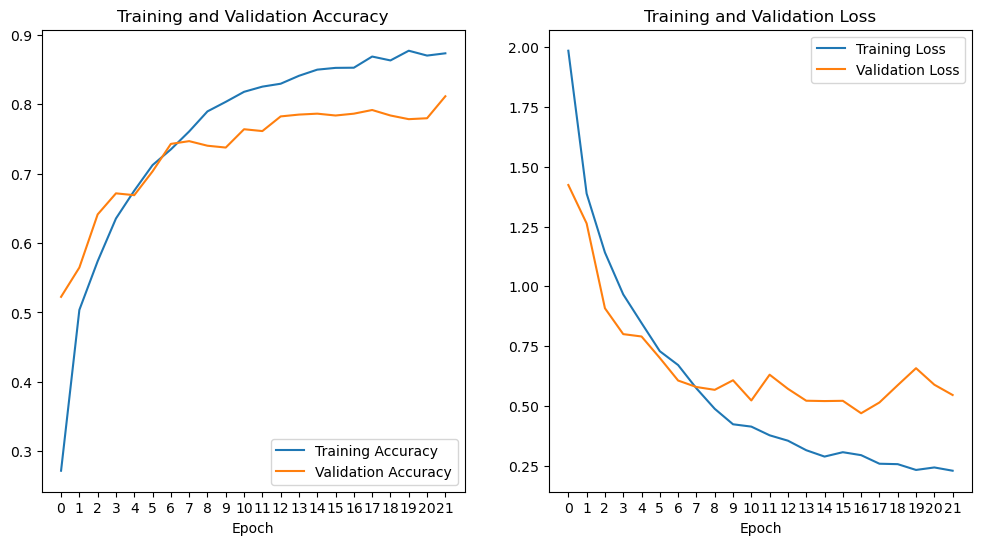

In [28]:
acc = tuned_history.history['accuracy']
val_acc = tuned_history.history['val_accuracy']
loss = tuned_history.history['loss']
val_loss = tuned_history.history['val_loss']

epochs_range = range(len(tuned_history.history['accuracy'])) 
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)  
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(epochs_range)
plt.xlabel('Epoch')

# Subplot for loss
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xticks(epochs_range)
plt.xlabel('Epoch');

1/1 [==============================] - 0s 120ms/step


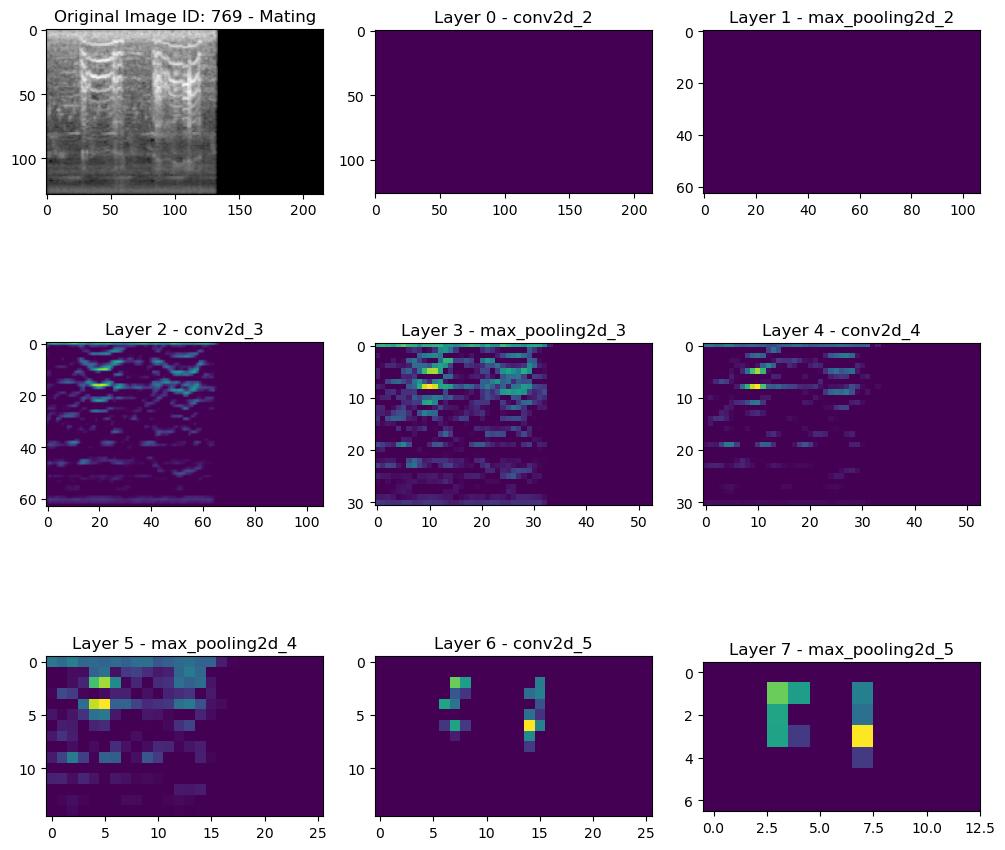

In [29]:
def plot_features_map(img_idx=None, layer_idx=range(8), 
                      x_test=X_test, ytest=y_test, model=tuned_model):
    if img_idx is None:
        img_idx = randint(0, ytest.shape[0])
    input_image = X_test[img_idx]
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    ax[0][0].imshow(input_image.squeeze(), cmap='gray')  # Assuming input is grayscale
    ax[0][0].set_title('Original Image ID: {} - {}'.format(img_idx, labels[np.argmax(ytest[img_idx])]))
    for i, l in enumerate(layer_idx):
        feature_map = get_feature_maps(model, l, input_image)
        ax[(i+1)//3][(i+1)%3].imshow(feature_map[0], cmap='viridis')
        ax[(i+1)//3][(i+1)%3].set_title('Layer {} - {}'.format(l, model.layers[l].name))
    plt.tight_layout()
    plt.show()
labels =  ['Angry','Defence','Fighting','Happy','HuntingMind','Mating','MotherCall','Paining','Resting','Warning']

plot_features_map()

# Transfer Learning Model - MobileNet <a name="transfer"></a>

In [30]:
# Base directory for data
base_dir = "NAYA_DATA_AUG1X"

# Output directories
output_base = "processed_data_mobilenet"
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'validation')
test_dir = os.path.join(output_base, 'test')
emotions_list =[]

# Create directories only if they do not contain files
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(dir, exist_ok=True)
    if not os.listdir(dir):  # Checks if directory is empty
        print(f"Directory {dir} is empty and will be filled with data.")
    else:
        print(f"Directory {dir} already has data, skipping processing.")
        continue  # Skip processing if data already exists

# Gather all audio files
data = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".mp3"):
            path = os.path.join(root, file)
            emotion = os.path.basename(root)
            data.append((path, emotion))

emotions_set = set()
for _, emotion in data:
    emotions_set.add(emotion)
emotions_list = list(emotions_set)

def process_and_save(files, output_dir):
    for file_path, emotion in tqdm(files):
        audio_data, sr = librosa.load(file_path, sr=None, mono=True)

        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        normalized_log_mel_spec = (log_mel_spec - np.min(log_mel_spec)) / (np.max(log_mel_spec) - np.min(log_mel_spec))

        image = Image.fromarray(np.uint8(normalized_log_mel_spec * 255))
        resized_image = image.resize((224, 224))

        class_dir = os.path.join(output_dir, emotion)
        os.makedirs(class_dir, exist_ok=True)
        image_file_name = os.path.basename(file_path).replace('.mp3', '.png')
        resized_image.save(os.path.join(class_dir, image_file_name))


# Check if directories are empty and process files accordingly
if not os.listdir(train_dir):
    train_files, test_files = train_test_split(data, test_size=0.30, stratify=[d[1] for d in data])
    val_files, test_files = train_test_split(test_files, test_size=0.5, stratify=[d[1] for d in test_files])
    process_and_save(train_files, train_dir)
    process_and_save(val_files, val_dir)
    process_and_save(test_files, test_dir)

Directory processed_data_mobilenet/train is empty and will be filled with data.
Directory processed_data_mobilenet/validation is empty and will be filled with data.
Directory processed_data_mobilenet/test is empty and will be filled with data.


 67%|██████▋   | 2777/4158 [01:53<00:58, 23.58it/s]Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
100%|██████████| 891/891 [00:36<00:00, 24.62it/s]


In [31]:
train_datagen = ImageDataGenerator(rescale=1./255,)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 4158 images belonging to 10 classes.
Found 891 images belonging to 10 classes.
Found 891 images belonging to 10 classes.


In [32]:
# Get the class indices for each generator
train_class_indices = train_generator.class_indices
val_class_indices = validation_generator.class_indices
test_class_indices = test_generator.class_indices

# Invert the dictionary to map indices to class names
train_idx_to_class = {v: k for k, v in train_class_indices.items()}
val_idx_to_class = {v: k for k, v in val_class_indices.items()}
test_idx_to_class = {v: k for k, v in test_class_indices.items()}

# Count the number of samples for each class
train_class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in train_idx_to_class.values()}
val_class_counts = {class_name: len(os.listdir(os.path.join(val_dir, class_name))) for class_name in val_idx_to_class.values()}
test_class_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in test_idx_to_class.values()}

# Print the class counts for each set
print("Training Set:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} samples")

print("\nValidation Set:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} samples")

print("\nTest Set:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} samples")


Training Set:
Angry: 420 samples
Defence: 420 samples
Fighting: 420 samples
Happy: 416 samples
HuntingMind: 405 samples
Mating: 421 samples
MotherCall: 414 samples
Paining: 408 samples
Resting: 414 samples

Validation Set:
Angry: 90 samples
Defence: 90 samples
Fighting: 90 samples
Happy: 89 samples
HuntingMind: 86 samples
Mating: 91 samples
MotherCall: 89 samples
Paining: 87 samples
Resting: 89 samples

Test Set:
Angry: 90 samples
Defence: 90 samples
Fighting: 90 samples
Happy: 89 samples
HuntingMind: 87 samples
Mating: 90 samples
MotherCall: 89 samples
Paining: 87 samples
Resting: 89 samples


In [33]:
# Load MobileNetV2 with pretrained ImageNet weights, excluding the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(len(emotions_list), activation='softmax')(x) 

# Model we train
mobile_net_model = Model(inputs=base_model.input, outputs=predictions)

mobile_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2, 
    restore_best_weights=True
)

mobile_net_history = mobile_net_model.fit(
    train_generator,
    epochs=20,  
    validation_data=validation_generator,
    callbacks=[early_stopping] 
)


Epoch 1/20
130/130 [==============================] - 23s 135ms/step - loss: 2.1768 - accuracy: 0.2241 - val_loss: 1.8777 - val_accuracy: 0.4029
Epoch 2/20
130/130 [==============================] - 13s 100ms/step - loss: 1.7071 - accuracy: 0.4726 - val_loss: 1.5629 - val_accuracy: 0.5253
Epoch 3/20
130/130 [==============================] - 13s 99ms/step - loss: 1.4548 - accuracy: 0.5479 - val_loss: 1.3852 - val_accuracy: 0.5690
Epoch 4/20
130/130 [==============================] - 13s 99ms/step - loss: 1.3061 - accuracy: 0.5878 - val_loss: 1.2754 - val_accuracy: 0.5814
Epoch 5/20
130/130 [==============================] - 13s 98ms/step - loss: 1.2068 - accuracy: 0.6128 - val_loss: 1.2049 - val_accuracy: 0.5881
Epoch 6/20
130/130 [==============================] - 13s 98ms/step - loss: 0.8795 - accuracy: 0.7015 - val_loss: 0.9603 - val_accuracy: 0.6218
Epoch 14/20
130/130 [==============================] - 13s 99ms/step - loss: 0.8569 - accuracy: 0.7121 - val_loss: 0.9479 - val_accura

In [35]:
test_loss, test_accuracy = mobile_net_model.evaluate(test_generator)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

28/28 [==============================] - 3s 89ms/step - loss: 0.9212 - accuracy: 0.6487
Test Loss: 0.9211947917938232
Test Accuracy: 0.6487092971801758


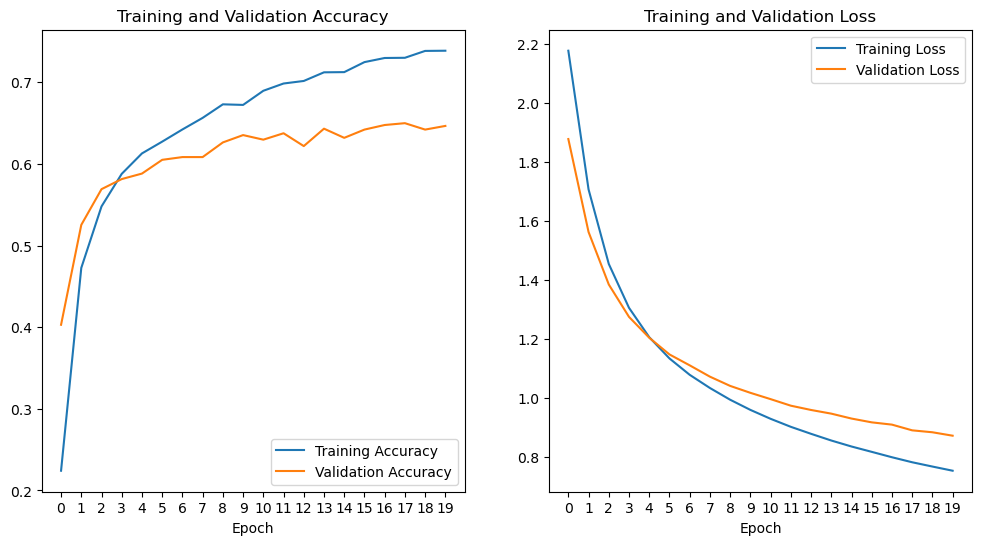

In [36]:
acc = mobile_net_history.history['accuracy']
val_acc = mobile_net_history.history['val_accuracy']
loss = mobile_net_history.history['loss']
val_loss = mobile_net_history.history['val_loss']

epochs_range = range(len(mobile_net_history.history['accuracy'])) 
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)  
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(epochs_range)
plt.xlabel('Epoch')

# Subplot for loss
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xticks(epochs_range)
plt.xlabel('Epoch');

# Model Performance <a name="performance"></a>

# Real Data <a name="real"></a>

In [129]:
emotions_onehot[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [155]:
# Load in data from Soline's cat named Blu
blu_audio, blu_sr = librosa.load("blu.mp3", sr=None, mono=True)

audio_data, sr = librosa.load(file_path)

desired_length = int(5 * sr)  
audio_padded = librosa.util.fix_length(audio_data, size=desired_length)

blu_mel_spec = librosa.feature.melspectrogram(y=audio_padded, sr=blu_sr)
blu_log_mel_spec = librosa.power_to_db(blu_mel_spec, ref=np.max)
blu_normalized_log_mel_spec = (blu_log_mel_spec - np.min(blu_log_mel_spec)) / (np.max(blu_log_mel_spec) - np.min(blu_log_mel_spec))

blu_emotion  = np.array([0,0,0,1,0,0,0,0,0,0]) # We think Blu was happy when his meow was recorded

# Turn Blu data into a tensorflow dataset
blu_data = tf.data.Dataset.from_tensor_slices(([blu_normalized_log_mel_spec], [blu_emotion]))
blu_data = blu_data.batch(1).prefetch(tf.data.AUTOTUNE)

### Baseline CNN Model

In [159]:
baseline_blu_preds = baseline_model.predict(blu_data)
baseline_blu_pred = np.argmax(baseline_blu_preds, axis=1)

1/1 [==============================] - 0s 70ms/step


In [160]:
baseline_predicted_label = label_encoder.inverse_transform(baseline_blu_pred)
baseline_predicted_label

array(['Resting'], dtype='<U11')

### Tuned CNN Model

In [161]:
tuned_blu_preds = tuned_model.predict(blu_data)
tuned_blu_pred = np.argmax(tuned_blu_preds, axis=1)

1/1 [==============================] - 0s 5ms/step


In [162]:
baseline_predicted_label = label_encoder.inverse_transform(tuned_blu_pred)
baseline_predicted_label

array(['MotherCall'], dtype='<U11')

### MobileNet

In [ ]:
## Predict real data on MobileNEt

# Convert to image and resize
image = Image.fromarray(np.uint8(normalized_log_mel_spec * 255))
resized_image = image.resize((224, 224))

# Convert grayscale image to RGB
rgb_image = resized_image.convert("RGB")

# Display the RGB image
plt.figure(figsize=(6, 4))
plt.imshow(rgb_image)
plt.title("RGB Image of Mel Spectrogram")
plt.axis('off')  # Hide axes
plt.show()

# Convert to array and add a batch dimension for prediction
image_array = np.array(rgb_image)[np.newaxis, :]

# Predict the class using the pre-trained model
predictions = mobilenet.predict(image_array)
predicted_class_index = np.argmax(predictions)
predicted_class = emotions_list[predicted_class_index]
print(f"The predicted emotion is: {predicted_class}")

# Results <a name="results"></a>

# Future Work/Scope of Improvement <a name="future"></a>